# Develop

Some basics of Keras and tensorflow I have learned with the help of these notebooks: [ImageGenerator](https://www.kaggle.com/sdelecourt/cnn-with-keras), [ROC curves](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb)

In [0]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import cross_val_score
import zipfile
from google.colab import files

### Define Data class

In [0]:
class Data:
    def __init__(self, train_path, train_labels_path, test_path, unique_identifier, target_class_column):
        self.train_path = train_path
        self.train_labels_path = train_labels_path
        self.test_path = test_path
    
        self.train_data_gen = ImageDataGenerator(validation_split = 0.2, 
                                                 # Fraction of images reserved for validation
                                                rescale = 1./255 ) # Normalize
        self.test_data_gen = ImageDataGenerator(rescale = 1./255)

        self.image_size = (96, 96)
        self.n_channels = 3
        self.unique_identifier = 'id'
        self.target_class_column = 'label'
        
        self.train_df = self._create_train_df(self.train_labels_path)
        
        self.test_df = self._create_test_df(self.test_path)
        self._create_data_generators()
        
    def _create_train_df(self, train_labels_path):
        train_df = self._load_target_labels(train_labels_path)
        train_df['id'] = train_df['id'].apply(lambda x: x+".tif")
        return train_df.astype({'label': 'str'})

    def _create_test_df(self, test_path):
        filenames =[]
        for dirname, _, filename in os.walk(test_path):
            filenames.extend(filename)
        return pd.DataFrame({"id":filenames})

    def _create_data_generators(self):
        pars = {'dataframe': self.train_df, 
                'directory': self.train_path, 
                'x_col': self.unique_identifier, # filenames of images
                'y_col': self.target_class_column, # class
                'target_size': self.image_size,
                'class_mode':'binary', 
                'batch_size': 64}

        self.train_generator = self.train_data_gen.flow_from_dataframe(**pars, subset = 'training') # specify if validation_split is specified in ImageDataGenerator
        self.validation_generator = self.train_data_gen.flow_from_dataframe(**pars, subset = 'validation') # specify if validation_split is specified in ImageDataGenerator
                                                        
        self.test_generator = self.test_data_gen.flow_from_dataframe(dataframe = self.test_df,
                                                    directory = test_path,
                                                    x_col = self.unique_identifier, # filename 
                                                    class_mode = None,
                                                    target_size = self.image_size,
                                                    batch_size = 1)
    def _load_target_labels(self, filename):
        return pd.read_csv(filename)

### Define Model Container class:

In [0]:
class CheckpointDownloadCallback(keras.callbacks.Callback):    
  def on_epoch_end(self, epoch, logs):
    filename = self.model.name + ".h5"
    print(filename)
    files.download(filename)  #Download from colab to local.

class ModelContainer:
    
    def __init__(self, models=[]):
        self.models = {}
        [self.add_model(model) for model in models]

        self.best_model_name = None
        self.predictions = None
        self.roc_auc = {}
        self.val_roc_auc = {} # Validation set
    
    def add_model(self, model):
        self.models[model.name] = model
    
    def train_model(self, data, model_name):
        # Do this one at a time since training these models takes considerable time
       
        model = self.models[model_name]

        checkpoint_cb = keras.callbacks.ModelCheckpoint(model.name + ".h5")
        #download_model_cb = CheckpointDownloadCallback()
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

        history = model.fit(data.train_generator, 
                            epochs = 15, 
                            validation_data = (data.validation_generator), 
                            #use_multiprocessing=True,
                            callbacks = [checkpoint_cb, early_stopping_cb])
 
        self.accuracy[model.name] = history.history['binary_accuracy'][-1]
        self.val_accuracy[model.name] = history.history['val_binary_accuracy'][-1]

    def select_best_model(self):
        # Selects and saves the best model. 
        self.best_model_name = min(self.roc_auc, key=self.roc_auc.get)
        # Save to file:
        self.models[self.best_model_name].save(self.best_model_name + ".h5")
        
    def best_model_predict(self, data_gen):
        self.predictions = self.models[self.best_model_name].predict(data_gen)
    
    def print_summary(self):
        print('\nModel Summaries:\n')
        for model in self.models:
            print('\n', model.name, '- Binary Accuracy:', models.accuracy[model])
            print('\n', model.name, '- Binary Validation Accuracy:', models.val_accuracy[model])

        print('\nBest Model:\n', self.best_model_name)
        print('\nROC AUC of Best Model\n', models.roc_auc[self.best_model_name])


### Define parameters for this project & download the data from Kaggle:

In [4]:
# Use this to upload the kaggle.json from your local machine:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!cp kaggle.json '/root/.kaggle/'
!chmod 600 '/root/.kaggle/kaggle.json'
!kaggle config set -n path -v '/content/'
!kaggle competitions download histopathologic-cancer-detection

- path is now set to: /content/
  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 44.0MB/s]
 98% 5.00M/5.10M [00:00<00:00, 30.7MB/s]
100% 5.10M/5.10M [00:00<00:00, 25.0MB/s]
 99% 1.29G/1.30G [00:16<00:00, 82.7MB/s]
100% 1.30G/1.30G [00:16<00:00, 84.7MB/s]
100% 4.97G/4.98G [01:19<00:00, 110MB/s]
100% 4.98G/4.98G [01:19<00:00, 67.3MB/s]


In [0]:
root_dir = '/content/competitions/histopathologic-cancer-detection/'
train_path = os.path.join(root_dir, 'train/')
test_path = os.path.join(root_dir, 'test/')
train_labels_path = os.path.join(root_dir, 'train_labels.csv/train_labels.csv')

unique_identifier = 'id'
target_class_column = 'label'

In [0]:
# Unzip files in all zipped directories:
os.chdir(root_dir)

for path_to_zip_file in os.listdir():
    new_directory = os.path.splitext(path_to_zip_file)[0]
    os.makedirs(new_directory, exist_ok=True)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(new_directory)
      zip_ref.close()

In [9]:
os.chdir(root_dir)
! ls -l | head -10

total 6616964
drwxr-xr-x 2 root root       4096 Oct 29 16:53 sample_submission.csv
-rw-r--r-- 1 root root    1394488 Oct 29 16:49 sample_submission.csv.zip
drwxr-xr-x 2 root root    4378624 Oct 29 16:53 test
-rw-r--r-- 1 root root 1401100547 Oct 29 16:49 test.zip
drwxr-xr-x 2 root root   16556032 Oct 29 16:52 train
drwxr-xr-x 2 root root       4096 Oct 29 16:53 train_labels.csv
-rw-r--r-- 1 root root    5352900 Oct 29 16:49 train_labels.csv.zip
-rw-r--r-- 1 root root 5346961539 Oct 29 16:50 train.zip


In [35]:
data = Data(train_path, train_labels_path, test_path, unique_identifier, target_class_column)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


## Make a baseline model:

In [0]:
baseline_layers = [
    keras.layers.Conv2D(filters = 64 , kernel_size = 7, activation = "relu", padding = "valid", input_shape = [data.image_size[0], data.image_size[1], data.n_channels]), 
    keras.layers.MaxPooling2D(pool_size = 2), 
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"), 
    keras.layers.Conv2D(128, 3 , activation = "relu" , padding = "same"), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(256, 3 , activation = "relu" , padding = "same"), 
    keras.layers.Conv2D(256, 3 , activation = "relu" , padding = "same"),   
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(), 
    keras.layers.Dense(128, activation = "relu"), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(64, activation = "relu"), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(1, activation = "sigmoid")
] 
baseline_model = keras.models.Sequential(baseline_layers, name = 'baseline')

baseline_model.compile(loss = keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(lr=0.001), metrics =['binary_accuracy'])

In [37]:
baseline_model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 90, 90, 64)        9472      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 256)       295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 256)       590

In [0]:
models = ModelContainer()
models.add_model(baseline_model)

In [39]:
models.models

{'baseline': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fc2f64aeeb8>}

In [40]:
models.train_model(data, baseline_model.name)

Epoch 1/15
2751/2751 [==============================] - 516s 187ms/step - loss: 0.6518 - binary_accuracy: 0.6138 - val_loss: 0.6101 - val_binary_accuracy: 0.6335
Epoch 2/15
2751/2751 [==============================] - 510s 185ms/step - loss: 0.5317 - binary_accuracy: 0.7578 - val_loss: 0.4750 - val_binary_accuracy: 0.7828
Epoch 3/15
2751/2751 [==============================] - 497s 181ms/step - loss: 0.4891 - binary_accuracy: 0.7831 - val_loss: 0.4536 - val_binary_accuracy: 0.7933
Epoch 4/15
2751/2751 [==============================] - 485s 176ms/step - loss: 0.4690 - binary_accuracy: 0.7941 - val_loss: 0.4320 - val_binary_accuracy: 0.8057
Epoch 5/15
2751/2751 [==============================] - 494s 180ms/step - loss: 0.4565 - binary_accuracy: 0.7995 - val_loss: 0.4469 - val_binary_accuracy: 0.7935
Epoch 6/15
2751/2751 [==============================] - 485s 176ms/step - loss: 0.4473 - binary_accuracy: 0.8049 - val_loss: 0.4614 - val_binary_accuracy: 0.7875
Epoch 7/15
2751/2751 [======

In [0]:
files.download("baseline.h5")

In [51]:
!ls -l | head -10

total 6640024
-rw-r--r-- 1 root root   20402728 Oct 29 19:38 baseline.h5
drwxr-xr-x 2 root root       4096 Oct 29 16:53 sample_submission.csv
-rw-r--r-- 1 root root    1394488 Oct 29 16:49 sample_submission.csv.zip
-rw-r--r-- 1 root root    3206753 Oct 29 20:59 submission.csv
drwxr-xr-x 2 root root    4378624 Oct 29 16:53 test
-rw-r--r-- 1 root root 1401100547 Oct 29 16:49 test.zip
drwxr-xr-x 2 root root   16556032 Oct 29 16:52 train
drwxr-xr-x 2 root root       4096 Oct 29 16:53 train_labels.csv
-rw-r--r-- 1 root root    5352900 Oct 29 16:49 train_labels.csv.zip


In [42]:
models.select_best_model()
models.best_model_name


'baseline'

In [0]:
models.print_summary()


In [0]:
models.best_model_predict(data.test_generator)

In [45]:
models.predictions.shape

(57458, 1)

In [0]:
models.best_model_predict(data.validation_generator)

In [62]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(data.validation_generator.classes, models.predictions)
auc_score = auc(false_pos_rate, true_pos_rate)
auc_score

0.4972746709380888

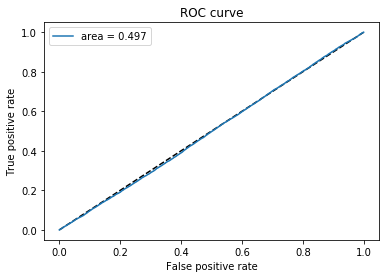

In [65]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_pos_rate, true_pos_rate, label='area = {:.3f}'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Submission to Kaggle:

In [0]:
models.best_model_predict(data.test_generator)

In [0]:
# Predictions were made in the order of the test_df using the test generator:
submission = data.test_df
submission['label'] = models.predictions
# Take out the extension for the submission:
submission['id'] = submission['id'].apply(lambda x: x.split(".")[0])

submission.to_csv("submission.csv", index = False, header = True)


In [57]:
submission.head()

,id,label
0,5d8721415d9480961c2d72e63343a64c7f656048,0.075276
1,9527fb2270fe6e386db403ab2a921d2e57ae2d02,0.122981
2,1ae9525a90929a70ce0c91e2d76ad8b9d5fb7c4a,0.064698
3,e812221e6331fc3ba9809c3f86db3579253bc2ab,0.611433
4,c1cc4da4d3e111f63959b1c984ecbb0806879099,0.070948


In [0]:
files.download("submission.csv")

In [59]:
!kaggle competitions submit -c histopathologic-cancer-detection -f submission.csv -m "Message"

100% 2.84M/2.84M [00:07<00:00, 414kB/s]
Successfully submitted to Histopathologic Cancer Detection